In [156]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from scrapData import GetHouseList
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import f_regression,SelectKBest
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import PolynomialFeatures,OneHotEncoder
from sklearn import linear_model,ensemble
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.decomposition import PCA,TruncatedSVD
np.random.seed(123)

# Data Scrapping

In [3]:
df=pd.DataFrame(columns=['title','price','location','property_type','bedrooms','bathrooms','area','amenities','creattion_date'])

In [6]:
# scrapping data from propertyfinder website
data=GetHouseList(150,400)
new_df=pd.DataFrame(columns=['title','price','location','property_type','bedrooms','bathrooms','area','amenities','creattion_date'],\
                    data=data)
df=pd.concat([df,new_df],axis=0)


151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400


In [7]:
df.to_csv('Apartment_data_propertyfinder_Amenities_3.csv',index=False)

In [8]:
df=pd.read_csv('Apartment_data_propertyfinder_Amenities_3.csv')
df.shape

(9571, 9)

# Data Cleaning

In [3]:
df=pd.read_csv('Apartment_data_propertyfinder_Amenities_3.csv')
df.head()

,title,price,location,property_type,bedrooms,bathrooms,area,amenities,creattion_date
0,المنصور اقوى مشروع بمدينة نصر TRUE شقة محسوبة صح,"\n 996,000\n EGP","True, Nasr City Compounds, Nasr City, Cairo",Apartment,3,2,120 sqm,"['Partly furnished', 'Security', 'Balcony', 'S...",Listed:2 hours ago
1,"Apartment 10Years Installment 260,000 Down Pay...","\n 2,600,000\n EGP","Hyde Park, 5th Settlement Compounds, The 5th S...",Apartment,2,2,135 sqm,"['Unfurnished', 'Kitchen Appliances', 'Central...",Listed:1 hour ago
2,Flat With Zero Over - Prime Location In Galler...,"\n 1,300,000\n EGP","Galleria Moon Valley, South Investors Area, Ne...",Apartment,3,3,196 sqm,"['Unfurnished', 'Security', 'Balcony', 'Shared...",Listed:23 hours ago
3,Amazing Flat 278 m at Eastown Sodic prime loca...,"\n 4,000,000\n EGP","Eastown, 5th Settlement Compounds, The 5th Set...",Apartment,4,4,278 sqm,"['Unfurnished', 'Security', 'Balcony', 'Pets A...",Listed:1 day ago
4,Modern Villa For Sale in Stone Park,"\n 8,000,000\n EGP","Stone Park, 5th Settlement Compounds, The 5th ...",Apartment,3,3,500 sqm,"['Partly furnished', 'Balcony', 'Study', 'Netw...",Listed:1 day ago


In [204]:
df.shape

(9571, 9)

In [4]:
# remove measure unit of price(EGP)
df['price']=df['price'].apply(lambda x: x.replace('EGP','').strip())
df.head()

,title,price,location,property_type,bedrooms,bathrooms,area,amenities,creattion_date
0,المنصور اقوى مشروع بمدينة نصر TRUE شقة محسوبة صح,"996,000","True, Nasr City Compounds, Nasr City, Cairo",Apartment,3,2,120 sqm,"['Partly furnished', 'Security', 'Balcony', 'S...",Listed:2 hours ago
1,"Apartment 10Years Installment 260,000 Down Pay...","2,600,000","Hyde Park, 5th Settlement Compounds, The 5th S...",Apartment,2,2,135 sqm,"['Unfurnished', 'Kitchen Appliances', 'Central...",Listed:1 hour ago
2,Flat With Zero Over - Prime Location In Galler...,"1,300,000","Galleria Moon Valley, South Investors Area, Ne...",Apartment,3,3,196 sqm,"['Unfurnished', 'Security', 'Balcony', 'Shared...",Listed:23 hours ago
3,Amazing Flat 278 m at Eastown Sodic prime loca...,"4,000,000","Eastown, 5th Settlement Compounds, The 5th Set...",Apartment,4,4,278 sqm,"['Unfurnished', 'Security', 'Balcony', 'Pets A...",Listed:1 day ago
4,Modern Villa For Sale in Stone Park,"8,000,000","Stone Park, 5th Settlement Compounds, The 5th ...",Apartment,3,3,500 sqm,"['Partly furnished', 'Balcony', 'Study', 'Netw...",Listed:1 day ago


In [5]:
# remove property type where all properties are Apartments
df.drop('property_type',axis=1,inplace=True)

In [6]:
# remove measure unit from area (sqm)
df['area']=df['area'].apply(lambda x: x.replace('sqm','').strip())
df.head()

,title,price,location,bedrooms,bathrooms,area,amenities,creattion_date
0,المنصور اقوى مشروع بمدينة نصر TRUE شقة محسوبة صح,"996,000","True, Nasr City Compounds, Nasr City, Cairo",3,2,120,"['Partly furnished', 'Security', 'Balcony', 'S...",Listed:2 hours ago
1,"Apartment 10Years Installment 260,000 Down Pay...","2,600,000","Hyde Park, 5th Settlement Compounds, The 5th S...",2,2,135,"['Unfurnished', 'Kitchen Appliances', 'Central...",Listed:1 hour ago
2,Flat With Zero Over - Prime Location In Galler...,"1,300,000","Galleria Moon Valley, South Investors Area, Ne...",3,3,196,"['Unfurnished', 'Security', 'Balcony', 'Shared...",Listed:23 hours ago
3,Amazing Flat 278 m at Eastown Sodic prime loca...,"4,000,000","Eastown, 5th Settlement Compounds, The 5th Set...",4,4,278,"['Unfurnished', 'Security', 'Balcony', 'Pets A...",Listed:1 day ago
4,Modern Villa For Sale in Stone Park,"8,000,000","Stone Park, 5th Settlement Compounds, The 5th ...",3,3,500,"['Partly furnished', 'Balcony', 'Study', 'Netw...",Listed:1 day ago


In [7]:
#check null values
df.isna().sum()

title             0
price             0
location          0
bedrooms          0
bathrooms         0
area              0
amenities         0
creattion_date    0
dtype: int64

In [8]:
# check all values of Bedrooms columns
df.bedrooms.unique()

array(['3 ', '2 ', '4 ', '1 ', '5 ', 'studio ', '7+ ', '6 ', '7 ', 'N/A '],
      dtype=object)

In [9]:
# remove usefulless spaces 
df.bedrooms=df.bedrooms.apply(lambda x:x.strip())
df.bedrooms.value_counts()

3         5915
2         2567
4          669
1          246
studio      84
5           63
6           17
7+           5
N/A          3
7            2
Name: bedrooms, dtype: int64

In [11]:
# replace 'N/A' with 0 and studio with 0 
df.bedrooms=df.bedrooms.apply(lambda x: x.replace('N/A','0'))
df.bedrooms=df.bedrooms.apply(lambda x: x.replace('studio','0'))

In [12]:
# extract numbers from bedrooms and bathrooms columns
df.bedrooms=df.bedrooms.apply(lambda x:re.findall('\d+',x)[0])
df.bathrooms=df.bathrooms.apply(lambda x:re.findall('\d+',x)[0])

In [12]:
df.head()

,title,price,location,bedrooms,bathrooms,area,amenities,creattion_date
0,المنصور اقوى مشروع بمدينة نصر TRUE شقة محسوبة صح,"996,000","True, Nasr City Compounds, Nasr City, Cairo",3,2,120,"['Partly furnished', 'Security', 'Balcony', 'S...",Listed:2 hours ago
1,"Apartment 10Years Installment 260,000 Down Pay...","2,600,000","Hyde Park, 5th Settlement Compounds, The 5th S...",2,2,135,"['Unfurnished', 'Kitchen Appliances', 'Central...",Listed:1 hour ago
2,Flat With Zero Over - Prime Location In Galler...,"1,300,000","Galleria Moon Valley, South Investors Area, Ne...",3,3,196,"['Unfurnished', 'Security', 'Balcony', 'Shared...",Listed:23 hours ago
3,Amazing Flat 278 m at Eastown Sodic prime loca...,"4,000,000","Eastown, 5th Settlement Compounds, The 5th Set...",4,4,278,"['Unfurnished', 'Security', 'Balcony', 'Pets A...",Listed:1 day ago
4,Modern Villa For Sale in Stone Park,"8,000,000","Stone Park, 5th Settlement Compounds, The 5th ...",3,3,500,"['Partly furnished', 'Balcony', 'Study', 'Netw...",Listed:1 day ago


In [13]:
df.bedrooms.value_counts()

3    5915
2    2567
4     669
1     246
0      87
5      63
6      17
7       7
Name: bedrooms, dtype: int64

In [14]:
# reorder columns
df=df.loc[:,['title','location','bedrooms','bathrooms','area','amenities','creattion_date','price']]
df.head()

,title,location,bedrooms,bathrooms,area,amenities,creattion_date,price
0,المنصور اقوى مشروع بمدينة نصر TRUE شقة محسوبة صح,"True, Nasr City Compounds, Nasr City, Cairo",3,2,120,"['Partly furnished', 'Security', 'Balcony', 'S...",Listed:2 hours ago,"996,000"
1,"Apartment 10Years Installment 260,000 Down Pay...","Hyde Park, 5th Settlement Compounds, The 5th S...",2,2,135,"['Unfurnished', 'Kitchen Appliances', 'Central...",Listed:1 hour ago,"2,600,000"
2,Flat With Zero Over - Prime Location In Galler...,"Galleria Moon Valley, South Investors Area, Ne...",3,3,196,"['Unfurnished', 'Security', 'Balcony', 'Shared...",Listed:23 hours ago,"1,300,000"
3,Amazing Flat 278 m at Eastown Sodic prime loca...,"Eastown, 5th Settlement Compounds, The 5th Set...",4,4,278,"['Unfurnished', 'Security', 'Balcony', 'Pets A...",Listed:1 day ago,"4,000,000"
4,Modern Villa For Sale in Stone Park,"Stone Park, 5th Settlement Compounds, The 5th ...",3,3,500,"['Partly furnished', 'Balcony', 'Study', 'Netw...",Listed:1 day ago,"8,000,000"


In [14]:
# remove the comma in the price 
df.price=df.price.apply(lambda x: x.replace(',',''))
df.area=df.area.apply(lambda x: x.replace(',',''))

In [17]:
# check data types
df.dtypes

title             object
price             object
location          object
bedrooms          object
bathrooms         object
area              object
amenities         object
creattion_date    object
dtype: object

In [19]:
# change bedrooms, bathrooms and area into integers, and price into float
df.bedrooms=df.bedrooms.astype(int)
df.bathrooms=df.bathrooms.astype(int)
df.area=df.area.astype(int)
df.price=df.price.astype(float)
df.head()

,title,price,location,bedrooms,bathrooms,area,amenities,creattion_date
0,المنصور اقوى مشروع بمدينة نصر TRUE شقة محسوبة صح,996000.0,"True, Nasr City Compounds, Nasr City, Cairo",3,2,120,"['Partly furnished', 'Security', 'Balcony', 'S...",Listed:2 hours ago
1,"Apartment 10Years Installment 260,000 Down Pay...",2600000.0,"Hyde Park, 5th Settlement Compounds, The 5th S...",2,2,135,"['Unfurnished', 'Kitchen Appliances', 'Central...",Listed:1 hour ago
2,Flat With Zero Over - Prime Location In Galler...,1300000.0,"Galleria Moon Valley, South Investors Area, Ne...",3,3,196,"['Unfurnished', 'Security', 'Balcony', 'Shared...",Listed:23 hours ago
3,Amazing Flat 278 m at Eastown Sodic prime loca...,4000000.0,"Eastown, 5th Settlement Compounds, The 5th Set...",4,4,278,"['Unfurnished', 'Security', 'Balcony', 'Pets A...",Listed:1 day ago
4,Modern Villa For Sale in Stone Park,8000000.0,"Stone Park, 5th Settlement Compounds, The 5th ...",3,3,500,"['Partly furnished', 'Balcony', 'Study', 'Netw...",Listed:1 day ago


In [20]:
df[['bedrooms','bathrooms','area','price']].corr()

,bedrooms,bathrooms,area,price
bedrooms,1.000000,0.617682,0.005950,0.191406
bathrooms,0.617682,1.000000,-0.004822,0.269481
area,0.005950,-0.004822,1.000000,-0.000567
price,0.191406,0.269481,-0.000567,1.000000


In [18]:
#check
df.dtypes

title              object
location           object
bedrooms            int32
bathrooms           int32
area                int32
amenities          object
creattion_date     object
price             float64
dtype: object

In [19]:
# check Compounds
df[df.location.str.contains('Compounds')].iloc[:,1].shape[0]

4338

In [20]:
# add new column to determine if the appartment in compound or not
df=df.reset_index(drop=True)
df['compound']=0
count=0
for index,(location,title) in enumerate(zip(df.location,df.title)):
    if ('Compounds' in location) or ('compound' in title.lower()) :
        df.loc[index,'compound']=1    

In [21]:
df.compound.value_counts()

0    5078
1    4493
Name: compound, dtype: int64

In [22]:
#check for duplicates
df[df.duplicated()].shape[0]

864

In [23]:
df.shape[0]

9571

In [24]:
#drop duplicates
df.drop_duplicates(inplace=True)#default keep first row
df.shape[0]

8707

In [25]:
# drop creation date
df.drop('creattion_date',axis=1,inplace=True)

In [26]:
#check
df.columns

Index(['title', 'location', 'bedrooms', 'bathrooms', 'area', 'amenities',
       'price', 'compound'],
      dtype='object')

In [27]:
def add_neighborhood(loc):
    #print(loc)
    neigh=np.nan
    if len(loc)>=3:
        neigh=loc[-3].strip()
    else:#less than three
        neigh=loc[-2].strip()
        #print(neigh)
    return neigh
df['location_neighborhood']=df.location.apply(lambda x : add_neighborhood(x.split(',')))
df['location_city']=df.location.apply(lambda x : x.split(',')[-2])
df.tail()

,title,location,bedrooms,bathrooms,area,amenities,price,compound,location_neighborhood,location_city
9566,مدينتي. مجموعة ١٠١. بي ١٠. دور خامس.,"Madinaty, Cairo",3,2,116,"['Unfurnished', 'Security', 'Balcony', 'View o...",750000.0,0,Madinaty,Madinaty
9567,للبيع شقه بالرحاب بمساحه 162متر لقطه,"El Rehab Extension, Al Rehab, New Cairo City, ...",3,3,162,"['Unfurnished', 'Security', 'Balcony', 'Shared...",2000000.0,0,Al Rehab,New Cairo City
9568,شقه 189 متربلوم فيلدز في مدينه المستقبل,"Bloomfields, Mostakbal City Compounds, Mostakb...",3,3,189,"['Unfurnished', 'Security', 'Concierge', 'Walk...",1050000.0,1,Mostakbal City Compounds,Mostakbal City - Future City
9569,استلام ٣ سنوات ١٠٪؜ مقدم ١٠ سنوات قسط متساوي,"5th Settlement Compounds, The 5th Settlement, ...",3,3,170,"['Unfurnished', 'Security', 'Private Garden', ...",3200000.0,1,The 5th Settlement,New Cairo City
9570,ستلم وحدتك في خلال سنه فقط في كمبوند Stone res...,"5th Settlement Compounds, The 5th Settlement, ...",4,3,128,"['Unfurnished', 'Security', 'Private Garden', ...",2200000.0,1,The 5th Settlement,New Cairo City


In [28]:
# get unique aminities 
uniq_list=[]
for am in df.amenities:
    for item in ast.literal_eval(am):
        if item.strip() not in uniq_list:
            uniq_list.append(item.strip())
print(uniq_list,len(uniq_list))

['Partly furnished', 'Security', 'Balcony', 'Shared Gym', 'Networked', 'Shared Pool', 'View of Water', 'View of Landmark', "Children's Play Area", 'Barbecue Area', 'Covered Parking', 'Shared Spa', 'Unfurnished', 'Kitchen Appliances', 'Central A/C', "Children's Pool", 'Concierge', 'Built in Wardrobes', 'Lobby in Building', 'Study', 'Walk-in Closet', 'Pets Allowed', 'Maid Service', 'Private Garden', 'Maids Room', 'Private Gym', 'Private Jacuzzi', 'Private Pool', 'Furnished'] 29


In [29]:
#create new columns from the unique aminities
df=df.reset_index(drop=True)
for aminity in uniq_list:
    # add new column
    #df.drop(aminity,axis=1,inplace=True)
    df[aminity]=0
    for index,am in enumerate(df.amenities): 
        if aminity in am:
            #print(index,aminity,am)
            #print(am)
            df.loc[index,aminity]=1
            #break

In [30]:
len(df)

8707

In [31]:
#check if aminity columns added correctly
print(df.iloc[74,10:])
print(df.loc[74,['amenities']].values)

Partly furnished        0
Security                0
Balcony                 1
Shared Gym              0
Networked               1
Shared Pool             0
View of Water           0
View of Landmark        1
Children's Play Area    0
Barbecue Area           0
Covered Parking         0
Shared Spa              0
Unfurnished             0
Kitchen Appliances      0
Central A/C             0
Children's Pool         0
Concierge               1
Built in Wardrobes      0
Lobby in Building       0
Study                   0
Walk-in Closet          1
Pets Allowed            1
Maid Service            0
Private Garden          0
Maids Room              0
Private Gym             0
Private Jacuzzi         0
Private Pool            0
Furnished               1
Name: 74, dtype: object
["['Furnished', 'Concierge', 'Balcony', 'Walk-in Closet', 'Networked', 'Pets Allowed', 'View of Landmark']"]


In [32]:
# drop amenities column
df.drop('amenities',axis=1,inplace=True)
df.columns

Index(['title', 'location', 'bedrooms', 'bathrooms', 'area', 'price',
       'compound', 'location_neighborhood', 'location_city',
       'Partly furnished', 'Security', 'Balcony', 'Shared Gym', 'Networked',
       'Shared Pool', 'View of Water', 'View of Landmark',
       'Children's Play Area', 'Barbecue Area', 'Covered Parking',
       'Shared Spa', 'Unfurnished', 'Kitchen Appliances', 'Central A/C',
       'Children's Pool', 'Concierge', 'Built in Wardrobes',
       'Lobby in Building', 'Study', 'Walk-in Closet', 'Pets Allowed',
       'Maid Service', 'Private Garden', 'Maids Room', 'Private Gym',
       'Private Jacuzzi', 'Private Pool', 'Furnished'],
      dtype='object')

In [33]:
# rename columns to replace spaces with (_)
for i in df.columns:
    if " " in i:
        df.rename(columns={i:"_".join(word for word in i.split(" "))},inplace=True)
df.columns

Index(['title', 'location', 'bedrooms', 'bathrooms', 'area', 'price',
       'compound', 'location_neighborhood', 'location_city',
       'Partly_furnished', 'Security', 'Balcony', 'Shared_Gym', 'Networked',
       'Shared_Pool', 'View_of_Water', 'View_of_Landmark',
       'Children's_Play_Area', 'Barbecue_Area', 'Covered_Parking',
       'Shared_Spa', 'Unfurnished', 'Kitchen_Appliances', 'Central_A/C',
       'Children's_Pool', 'Concierge', 'Built_in_Wardrobes',
       'Lobby_in_Building', 'Study', 'Walk-in_Closet', 'Pets_Allowed',
       'Maid_Service', 'Private_Garden', 'Maids_Room', 'Private_Gym',
       'Private_Jacuzzi', 'Private_Pool', 'Furnished'],
      dtype='object')

In [34]:
df.head()

,title,location,bedrooms,bathrooms,area,price,compound,location_neighborhood,location_city,Partly_furnished,...,Study,Walk-in_Closet,Pets_Allowed,Maid_Service,Private_Garden,Maids_Room,Private_Gym,Private_Jacuzzi,Private_Pool,Furnished
0,المنصور اقوى مشروع بمدينة نصر TRUE شقة محسوبة صح,"True, Nasr City Compounds, Nasr City, Cairo",3,2,120,996000.0,1,Nasr City Compounds,Nasr City,1,...,0,0,0,0,0,0,0,0,0,0
1,"Apartment 10Years Installment 260,000 Down Pay...","Hyde Park, 5th Settlement Compounds, The 5th S...",2,2,135,2600000.0,1,The 5th Settlement,New Cairo City,0,...,1,1,1,0,0,0,0,0,0,0
2,Flat With Zero Over - Prime Location In Galler...,"Galleria Moon Valley, South Investors Area, Ne...",3,3,196,1300000.0,0,South Investors Area,New Cairo City,0,...,0,0,1,0,0,0,0,0,0,0
3,Amazing Flat 278 m at Eastown Sodic prime loca...,"Eastown, 5th Settlement Compounds, The 5th Set...",4,4,278,4000000.0,1,The 5th Settlement,New Cairo City,0,...,0,0,1,0,0,0,0,0,0,0
4,Modern Villa For Sale in Stone Park,"Stone Park, 5th Settlement Compounds, The 5th ...",3,3,500,8000000.0,1,The 5th Settlement,New Cairo City,1,...,1,0,0,0,0,0,0,0,0,0


In [35]:
df.to_csv('data_cleaned.csv',index=False)

# Exploratory Data Analysis

In [2]:
df=pd.read_csv('data_cleaned.csv')
df=df[df.price<=7000000  ]
df=df[ df.area<=300 ]

df.shape

(8354, 38)

In [54]:

df=df[df.location_city.isin(df.location_city.value_counts().reset_index(name='count').query('count>10')['index'])]
df.shape

(8282, 38)

In [23]:
df.location_city.value_counts()

 New Cairo City                  4905
 New Capital City                1085
Madinaty                          844
 Nasr City                        239
 Hay El Maadi                     233
 Mostakbal City - Future City     229
 Shorouk City                     214
 Heliopolis - Masr El Gedida      176
 Mokattam                         148
 Zamalek                           61
 El Nozha                          58
 Ring Road                         56
 New Heliopolis                    34
Name: location_city, dtype: int64

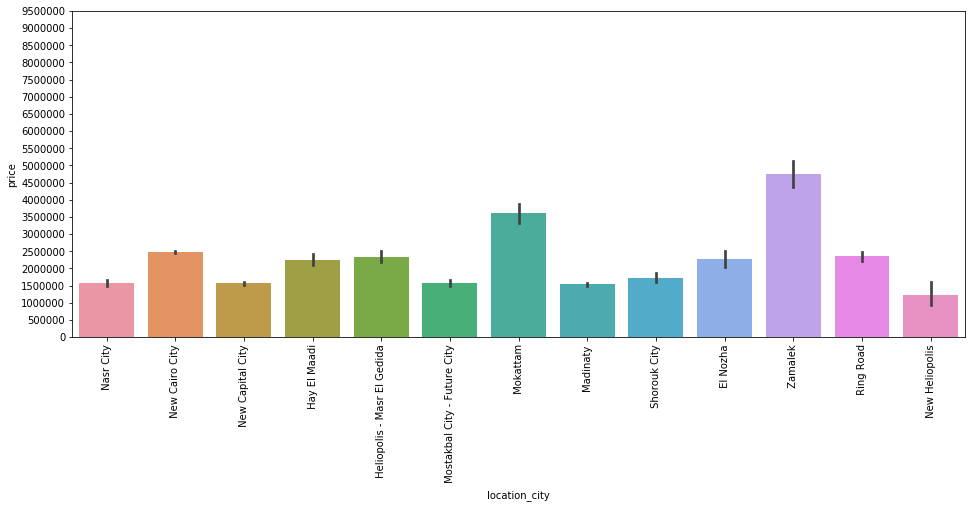

In [24]:
plt.figure(figsize=(16,6))
sns.barplot(x= 'location_city',y='price',data=df)
plt.yticks(np.arange(0, 10000000, 500000))
plt.xticks(rotation=90);


### What is the relation between area and salary?

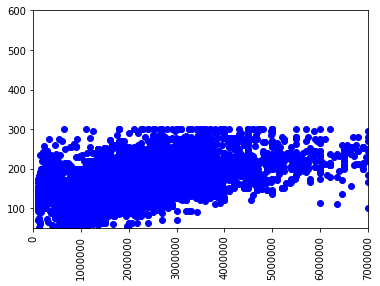

In [7]:
plt.scatter(x='price',y='area',data=df,color='blue')
plt.ylim(50,600)
plt.xlim(0,7000000)
plt.xticks(rotation=90);

(0, 400)

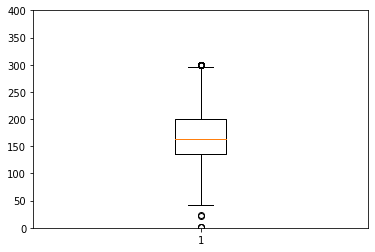

In [122]:
plt.boxplot(df.area)
plt.ylim(0,400)

In [132]:
median = np.median(df.area)
upper_quartile = np.percentile(df.area, 75)
lower_quartile = np.percentile(df.area, 25)

iqr = upper_quartile - lower_quartile
upper_whisker = df.area[df.area<=upper_quartile+1.5*iqr].max()
lower_whisker = df.area[df.area>=lower_quartile-1.5*iqr].min()
print("median: {} , Q3: {}, Q1: {},upper_whisker: {} ,lower_whisker: {}".format(median,upper_quartile,lower_quartile,upper_whisker,lower_whisker))

median: 164.0 , Q3: 200.0, Q1: 135.0,upper_whisker: 296 ,lower_whisker: 42


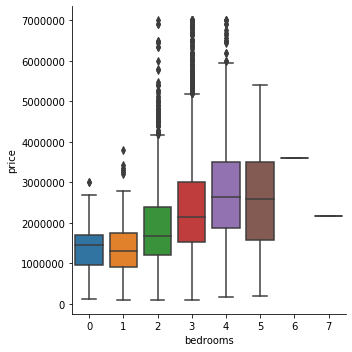

In [127]:
sns.catplot(x="bedrooms", y="price", kind="box", data=df)

(100000, 6000000)

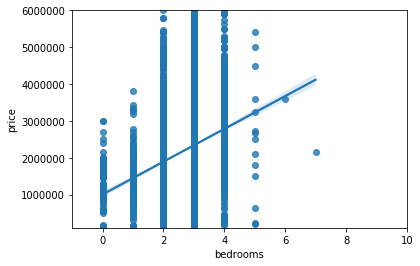

In [21]:
sns.regplot(y='price',x='bedrooms',data=df)
plt.xlim(-1,10)
plt.ylim(100000,6000000)
#plt.xticks(rotation=90)

bedrooms seem not significant because most of categories are overlapped in price

(100000, 6000000)

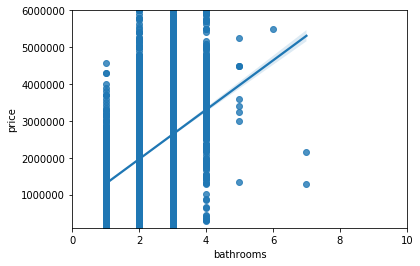

In [103]:
sns.regplot(y='price',x='bathrooms',data=df)
plt.xlim(0,10)
plt.ylim(100000,6000000)
#plt.xticks(rotation=90)

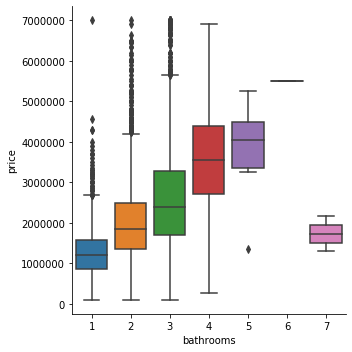

In [23]:
sns.catplot(x="bathrooms", y="price", kind="box", data=df)

### Correlation matrix

In [155]:
pipeline = Pipeline(steps=[('preprocessor',preprocessor)])
pipeline.fit(df).transform(df)
pipeline

AttributeError: 'Pipeline' object has no attribute 'columns'

In [121]:
corr=df.corr()

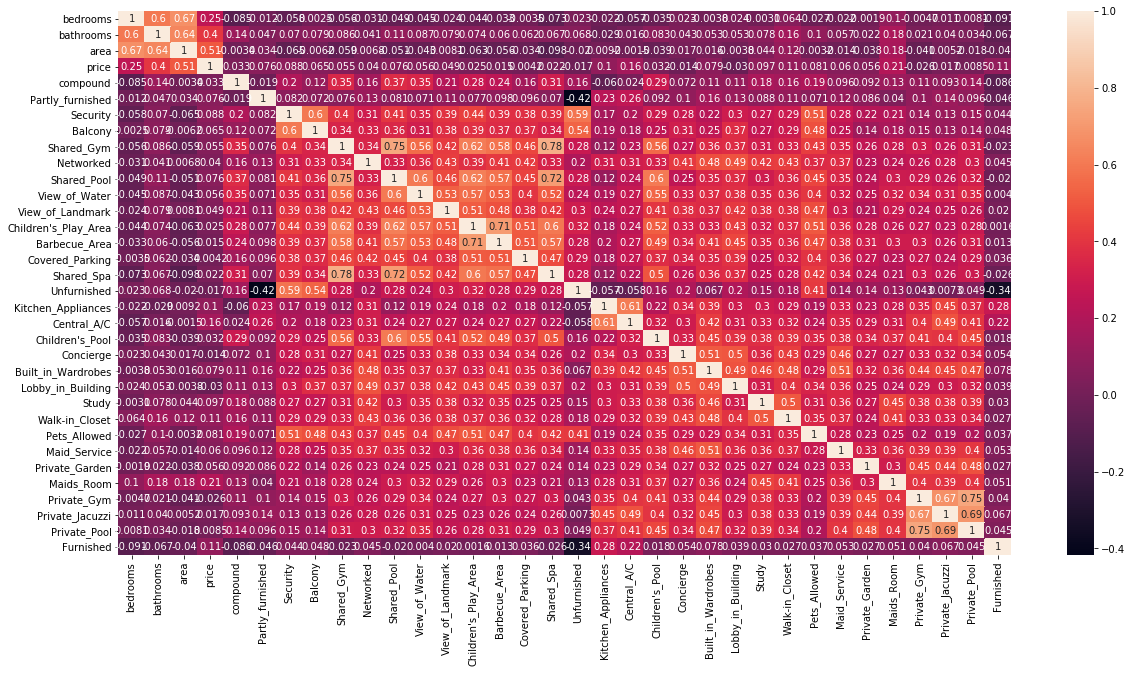

In [122]:
plt.figure(figsize=(20,10))
sns.heatmap(corr,annot = True)

In [126]:
corr.shape

(34, 34)

In [140]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.7:
            print(i,j)
            if columns[j]:
                columns[j] = False
print((columns),df.columns)
#selected_columns = df.columns[columns]
#df[selected_columns]


8 10
8 16
10 16
13 14
30 32
[ True  True  True  True  True  True  True  True  True  True False  True
  True  True False  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True] Index(['title', 'location', 'bedrooms', 'bathrooms', 'area', 'price',
       'compound', 'location_neighborhood', 'location_city',
       'Partly_furnished', 'Security', 'Balcony', 'Shared_Gym', 'Networked',
       'Shared_Pool', 'View_of_Water', 'View_of_Landmark',
       'Children's_Play_Area', 'Barbecue_Area', 'Covered_Parking',
       'Shared_Spa', 'Unfurnished', 'Kitchen_Appliances', 'Central_A/C',
       'Children's_Pool', 'Concierge', 'Built_in_Wardrobes',
       'Lobby_in_Building', 'Study', 'Walk-in_Closet', 'Pets_Allowed',
       'Maid_Service', 'Private_Garden', 'Maids_Room', 'Private_Gym',
       'Private_Jacuzzi', 'Private_Pool', 'Furnished'],
      dtype='object')


In [149]:
df.iloc[:,8:10].corr()

<bound method DataFrame.corr of                       location_city  Partly_furnished
0                         Nasr City                 1
1                    New Cairo City                 0
2                    New Cairo City                 0
3                    New Cairo City                 0
5                    New Cairo City                 0
...                             ...               ...
8702                       Madinaty                 0
8703                 New Cairo City                 0
8704   Mostakbal City - Future City                 0
8705                 New Cairo City                 0
8706                 New Cairo City                 0

[8282 rows x 2 columns]>

# Data Transformation and Feature selection

#### Apply one hot encoding on location_neighborhood and location_city

In [9]:
df_numerical=df.loc[:,df.columns.difference(['location_neighborhood', 'location_city','location','title','price'])]
df_features=df.loc[:,df.columns.difference(['location','title','price'])]
df_target=df.loc[:,'price']
df_numerical.columns

Index(['Balcony', 'Barbecue_Area', 'Built_in_Wardrobes', 'Central_A/C',
       'Children's_Play_Area', 'Children's_Pool', 'Concierge',
       'Covered_Parking', 'Furnished', 'Kitchen_Appliances',
       'Lobby_in_Building', 'Maid_Service', 'Maids_Room', 'Networked',
       'Partly_furnished', 'Pets_Allowed', 'Private_Garden', 'Private_Gym',
       'Private_Jacuzzi', 'Private_Pool', 'Security', 'Shared_Gym',
       'Shared_Pool', 'Shared_Spa', 'Study', 'Unfurnished', 'View_of_Landmark',
       'View_of_Water', 'Walk-in_Closet', 'area', 'bathrooms', 'bedrooms',
       'compound'],
      dtype='object')

We can`t standarize by mean and std because they are sensitive with outliers(there are many outliers)<br>
but we can normalize it by using min max scaler

#### Add ColumnTransformer for preprocessing (scalling and OneHotEncoder )

In [150]:
numeric_features = list(df_numerical.columns)
numeric_transformer = Pipeline(steps=[
    ('scaler', preprocessing.MinMaxScaler())])
categorical_features = ['location_neighborhood', 'location_city']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#### Get best features

In [67]:
fs = SelectKBest(score_func=f_regression, k=15)

#### split data

In [151]:
#split data to train/test
X=df_features
Y=df_target
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=40)
print('training set: ',X_train.shape,y_train.shape)
print('test set: ',X_test.shape,y_test.shape)
X.head(2)

training set:  (6659, 35) (6659,)
test set:  (1665, 35) (1665,)


,Balcony,Barbecue_Area,Built_in_Wardrobes,Central_A/C,Children's_Play_Area,Children's_Pool,Concierge,Covered_Parking,Furnished,Kitchen_Appliances,...,Unfurnished,View_of_Landmark,View_of_Water,Walk-in_Closet,area,bathrooms,bedrooms,compound,location_city,location_neighborhood
0,1,1,0,0,1,0,0,1,0,0,...,0,1,1,0,120,2,3,1,Nasr City,Nasr City Compounds
1,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,135,2,2,1,New Cairo City,The 5th Settlement


# Prediction

### 1. Linear Regression

In [25]:
# train the linear regression model
reg = linear_model.LinearRegression()
#reg.fit(X_train_fs,y_train)

In [26]:
svd = TruncatedSVD(n_components=63, n_iter=7, random_state=42)
pipeline = Pipeline(steps=[('preprocessor',preprocessor),('reduce_dim', svd), ('model', reg)])
pipeline.fit(X_train,y_train.ravel())
# test the accuracy 
y_hat=pipeline.predict(X_test)
print('R square:{:0.2f} '.format(r2_score(y_test,y_hat))) 

R square:0.58 


In [27]:
from sklearn import set_config

set_config(display='diagram')
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Balcony', 'Barbecue_Area',
                                                   'Built_in_Wardrobes',
                                                   'Central_A/C',
                                                   "Children's_Play_Area",
                                                   "Children's_Pool",
                                                   'Concierge',
                                                   'Covered_Parking',
                                                   'Furnished',
                                                   'Kitchen_Appliances',
                                                   'Lobby_in_Building',
                                                   'Maid_Service', 'Maids_Room',
                                                   'Networked',
                                                   'Partly_f...
                                                   'Private_Pool', 'Security',
                                                   'Shared_Gym', 'Shared_Pool',
                                                   'Shared_Spa', 'Study',
                                                   'Unfurnished',
                                                   'View_of_Landmark',
                                                   'View_of_Water',
                                                   'Walk-in_Closet', 'area', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['location_neighborhood',
                                                   'location_city'])])),
                ('reduce_dim',
                 TruncatedSVD(n_components=63, n_iter=7, random_state=42)),
                ('model', LinearRegression())])

### 2.  polynomial Regression

In [28]:
#### try polynomial
poly = PolynomialFeatures(degree=2)
reg = linear_model.LinearRegression()
svd = TruncatedSVD(n_components=63, n_iter=7, random_state=42)
pipeline = Pipeline(steps=[('preprocessor',preprocessor),('poly',poly),('reduce_dim', svd), 
                           ('model', reg)])
pipeline.fit(X_train,y_train.ravel())
# test the accuracy 
y_hat=pipeline.predict(X_test)
print('R square:{:0.2f} '.format(r2_score(y_test,y_hat))) 

R square:0.50 


### 3. KNN Regressor

In [55]:
np.arange(1,21)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [29]:
neigh = KNeighborsRegressor(n_neighbors=10)
pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                           ('model', neigh)])
pipeline = Pipeline(steps=[('preprocessor',preprocessor), ('model', neigh)])
pipeline.fit(X_train,y_train.ravel())
y_hat=pipeline.predict(X_test)
print('R square:{:0.2f} '.format(r2_score(y_test,y_hat))) 

R square:0.46 


### 4. Enssemble Learning (GBoost)

In [119]:
acc={}
params = {'n_estimators': 1000,#the number of boosting stages
          'max_depth': 6,#limits the number of nodes in the tree
          'min_samples_split': 3,# the minimum number of samples required to split an internal node.
          'learning_rate': 0.01,#how much the contribution of each tree will shrink.
          #'loss': 'ls',
          #'booster':'gblinear'
         }#loss function to optimize. The least squares function is used in this case

gBoost_model=ensemble.GradientBoostingRegressor(**params)
pipeline = Pipeline(steps=[('preprocessor',preprocessor), ('model', gBoost_model)])
pipeline.fit(X_train,y_train.ravel())
y_hat=pipeline.predict(X_test)
y_hat_train=pipeline.predict(X_train)
print('Test R square:{:0.2f} '.format(r2_score(y_test,y_hat))) 
print('Train R square:{:0.2f} '.format(r2_score(y_train,y_hat_train))) 

Test R square:0.62 
Train R square:0.71 


### 4. Enssemble Learning (XGBoost)

In [163]:
list(np.arange(.1,1,.1))

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]

In [165]:
params = {#'objective' :'reg:linear',#determines the loss function to be used like reg:linear for regression problems,reg:logistic
          'colsample_bytree' : .3,#percentage of features used per tree. High value can lead to overfitting 
          'learning_rate' : 0.02,#step size shrinkage used to prevent overfitting. Range is [0,1]
          'max_depth' : 4,#determines how deeply each tree is allowed to grow during any boosting round
          'alpha' : 10, #L1 regularization on leaf weights. A large value leads to more regularization.
          'n_estimators' :1000, #number of trees you want to build.
          #'booster':'gblinear'
         }#loss function to optimize. The least squares function is used in this case

param_grid = {
    'model__colsample_bytree': [.3,.7],
    'model__learning_rate': [.02,.06],
    'model__max_depth': [4,7],
    'model__alpha': [10,30],
    'model__n_estimators': [500,800],


    
}
xGBoost_model = xgb.XGBRegressor(**params)
pipeline = Pipeline(steps=[('preprocessor',preprocessor), ('model', xGBoost_model)])
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)
#pipeline.set_params(fs__k=63)
pipeline.fit(X_train,y_train.ravel())
y_hat=grid_search.predict(X_test)
y_hat_train=grid_search.predict(X_train)
print('Test R square:{:0.2f} '.format(r2_score(y_test,y_hat))) 
print('Train R square:{:0.2f} '.format(r2_score(y_train,y_hat_train))) 

Test R square:0.65 
Train R square:0.78 


In [15]:
from sklearn import set_config

set_config(display='diagram')
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Balcony', 'Barbecue_Area',
                                                   'Built_in_Wardrobes',
                                                   'Central_A/C',
                                                   "Children's_Play_Area",
                                                   "Children's_Pool",
                                                   'Concierge',
                                                   'Covered_Parking',
                                                   'Furnished',
                                                   'Kitchen_Appliances',
                                                   'Lobby_in_Building',
                                                   'Maid_Service', 'Maids_Room',
                                                   'Networked',
                                                   'Partly_f...
                              colsample_bytree=0.3, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=5, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
                              random_state=0, reg_alpha=10, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

0.6459681356707057


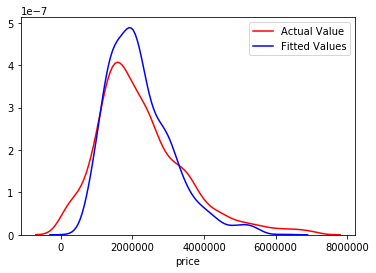

In [172]:
y_hat=grid_search.predict(X_test)
print(r2_score(y_test,y_hat))
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)

In [117]:

plt.barh(df.columns, pipeline.feature_importances_)

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'